### Prepare Data

In [ ]:
from glob import glob
from ConceptMining import ConceptMiner
from settings import settings

import pickle

In [ ]:
batch_size = 70
images = [i for i in glob("../dataset/Images/*.jpg")]
Miner = ConceptMiner(images = images, load_model= True)

# encodings, captions = Miner.get_image_caption(get_encodings = True, batch_size = batch_size)

In [ ]:
# with open('encodings.pkl', 'wb') as f:
#     pickle.dump({'encodings':encodings, 'captions': captions}, f)
with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

In [ ]:
concept_model, generated_concepts = Miner.concept_modeling(encodings = encodings, 
                                                           captions = captions, 
                                                           batch_size = batch_size)

with open("generated_concepts.pkl", "wb") as f:
    pickle.dump(generated_concepts, f)


### Cluser topics by semantic similarity 
- Cluser concepts
- Sample concepts taking as mean the centroid +- a random noice to simulate user externalization

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from umap import UMAP
import os, pickle
import numpy as np

from transformers import AutoTokenizer, AutoModel

with open("generated_concepts.pkl", "rb") as f:
    generated_concepts = list(set(pickle.load(f)) - {""})
    
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_embedding(sentences, model, tokenizer, batch_size = 16):
    with torch.no_grad():

        output = None
        for i in range(0, len(sentences), batch_size):
            encoded_input = tokenizer(sentences[i: i + batch_size], padding=True, return_tensors='pt')

            model_output = model(**encoded_input)
            sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

            sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
            output = sentence_embeddings if output is None else torch.cat([output, sentence_embeddings])

    return output

concepts_embeddings = get_embedding(generated_concepts, model, tokenizer, batch_size = 16)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

similarity_matrix = cosine_similarity(concepts_embeddings)

# Apply Spectral Clustering
num_clusters = 20
spectral = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# Group words by topic
topic_groups = {}
for word, cluster in zip(generated_concepts, labels):
    topic_groups.setdefault(cluster, []).append(word)
    
with open("generated_concepts.pkl", "wb") as f:
	pickle.dump({'concepts':generated_concepts,
              'topic_groups': topic_groups}, f)

#### Preprocess the data for simulation


In [ ]:
import pickle
from glob import glob

import random

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	data = pickle.load(f)
	encodings = data['encodings']
	captions = data['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

##### Encode all text and images to speed up training


In [6]:
from PIL import Image
import pickle
from tqdm import tqdm

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

batch_size = 70
# encode all images using output of a single text
image_encodings = []

for batch in tqdm(range(0, len(images), batch_size)):
	image = [Image.open(i) for i in images[batch: batch + batch_size]]
	inputs = processor(text=["a photo of a cat"] * len(image), images=image, return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	image_encodings += [outputs.image_embeds.cpu().detach()]

image_encodings = torch.cat(image_encodings)

# encode all concepts using output of a single image
concept_encodings = []
for batch in tqdm(range(0, len(generated_concepts), batch_size)):
	concepts = generated_concepts[batch: batch + batch_size]
	inputs = processor(text=concepts, images=[Image.open(images[0])], return_tensors="pt", padding=True).to("cuda")
	outputs = model(**inputs, return_dict = True)
	concept_encodings += [outputs.text_embeds.cpu().detach()]

concept_encodings = torch.cat(concept_encodings)
with open("clip_encodings.pkl", "wb") as f:
	pickle.dump({'image_encodings': image_encodings,
			  'concept_encodings': concept_encodings}, f)

100%|██████████| 9/9 [00:00<00:00, 32.81it/s]


In [ ]:
concept_instance = {i:[] for i in generated_concepts}

for i, path in enumerate(images):
	for c in captions[i].split():
		if c in generated_concepts:
			concept_instance[c] += [path]

remove_topics = []
for i in topic_groups:
	remove = [j for j in topic_groups[i] if len(concept_instance[j]) < 10]
	for j in remove:
		topic_groups[i].remove(j)
	print(f"Topic {i}:", len(topic_groups[i]))
	if len(topic_groups[i]) < 8:
		remove_topics.append(i)

for i in remove_topics:
	del topic_groups[i]

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 2: 7
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 6: 7
Topic 8: 18
Topic 16: 15
Topic 18: 5
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9
Topic 10: 0
Topic 15: 7


Text(0.5, 0, 'Concepts')

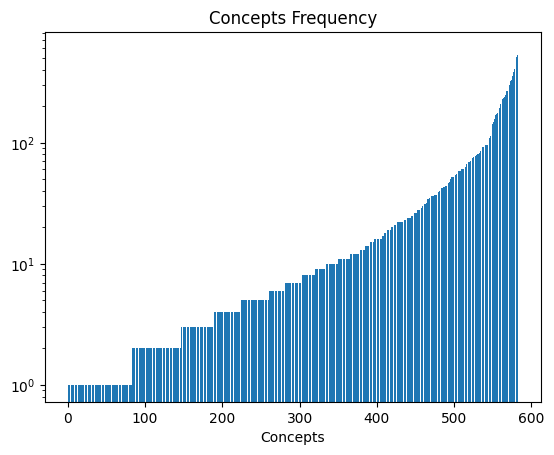

In [ ]:
from matplotlib import pyplot as plt	
plt.bar(range(len(generated_concepts)), sorted([len(i) for i in concept_instance.values()]), log = True)
plt.title("Concepts Frequency")
plt.xlabel("Concepts")

Text(0.5, 0, 'Topics')

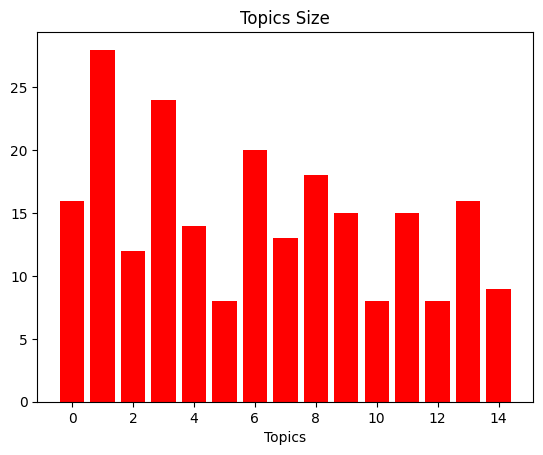

In [ ]:
plt.bar(range(len(topic_groups)), [len(topic_groups[i]) for i in topic_groups], color = 'r')
plt.title("Topics Size")
plt.xlabel("Topics")

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt

from ConceptPrompting import AdaptationEngine
from tqdm import tqdm
import torch


def encode_actions(action, n_actions):

	if not isinstance(action, torch.Tensor):
		action = torch.tensor(action)
	return torch.nn.functional.one_hot(action, num_classes=n_actions).float()

def preprocess_state(state):
	return torch.tensor(state).float().reshape(1, -1)

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

episodes = 400
episode_length = 1000
dataset_coverage_step = .75
gamma = 0.99
buffer = []
actions_embedd_dim = 2
buffer_size = 512

lr_actor = 0.001
lr_critic = 0.0001

temperature = 2.0
final_temperature = 0.1
decay_rate = 0.99  # Decay per episode

# env = gym.make('MountainCar-v0')
env = gym.make('CartPole-v1')

# Pi = Actor(state_dim = env.observation_space.shape[0], action_dim = actions_embedd_dim, lr_optimizer = lr_actor)
# V = Critic(state_dim = env.observation_space.shape[0], lr_optimizer = lr_critic)
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
						 	action_dim=env.action_space.n,
							lr_actor = lr_actor,
							lr_critic = lr_critic,
							gamma = gamma,
							buffer_size = buffer_size,
							sample_temperature = temperature,
							final_temperature = final_temperature,
							temperatura_decay = decay_rate)

actions_encode = encode_actions([i  for i in range(env.action_space.n)], env.action_space.n).to(Agent.device)

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}


for episode in range(episodes):

	prev_state, _ = env.reset()
	prev_state = preprocess_state(prev_state)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
			
	itera = tqdm(range(episode_length))
	itera.set_description(f"Episode {episode}")
	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, reward, done, truncated, _ = env.step(action.item())
		state = preprocess_state(state)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temperature': f'{temperature:.4f}',
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'Loss Critic': sum(episode_history['loss_critic']),
						'Loss Actor': sum(episode_history['loss_actor'])} )
		if done or truncated:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	temperature = max(final_temperature, temperature * decay_rate)
	if Agent.max_reward is None or Agent.max_reward < sum(episode_history['rewards']):
		Agent.max_reward = sum(episode_history['rewards'])
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")

env.close()

Text(0.5, 0, 'Iterations')

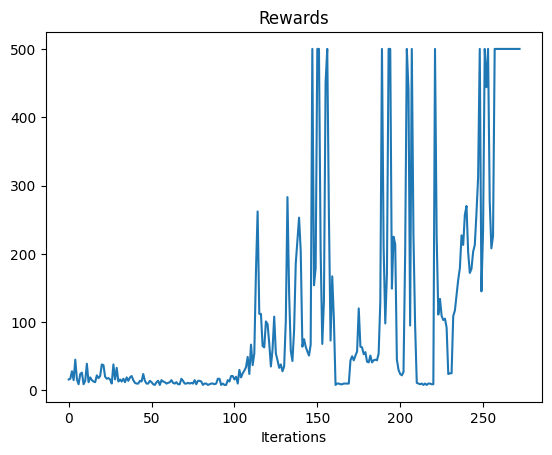

In [ ]:
plt.plot(history['rewards'])
plt.title("Rewards")
plt.xlabel("Iterations")

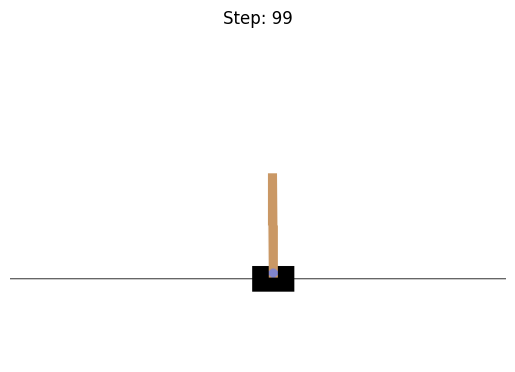

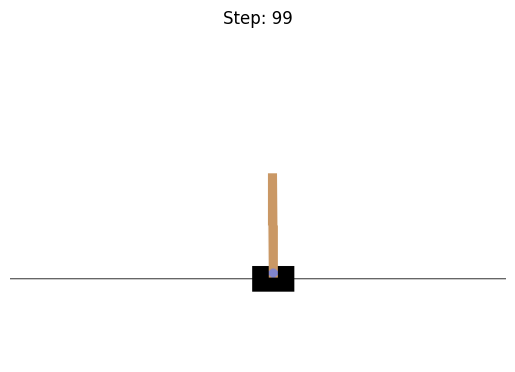

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title(f"Step: {step}")
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v1', render_mode='rgb_array')
Agent = AdaptationEngine(state_dim = env.observation_space.shape[0],
							action_dim=env.action_space.n)
                            
Agent.Actor.load('actor.pt')
# env = gym.make('MountainCar-v0', render_mode='rgb_array')

prev_state, info = env.reset()
prev_state = preprocess_state(prev_state)
print(prev_state)
for step in range(int(100)):
	preferences =  Agent.policy(prev_state, actions_encode)

	action = preferences.argmax()

	observation, reward, terminated, _, _ = env.step(action.item())
	print(action)

	prev_state = preprocess_state(observation)
	prev_action = action

	show_state(env, step=step)

	if terminated:
		print(observation)
		break

env.close()


### Exploration Agent

In [2]:
import pickle
from matplotlib import pyplot as plt
from glob import glob

from ConceptPrompting import AdaptationEngine, explore_environment
from settings import  pretraining_settings as settings
from tqdm import tqdm
import torch
import numpy as np

def get_entropy(preferences):
	return -torch.sum(preferences * torch.log(preferences), dim = -1)

with open("clip_encodings.pkl", "rb") as f:
	data = pickle.load(f)
	image_encodings = data['image_encodings']
	actions_encode = data['concept_encodings']

with open("generated_concepts.pkl", "rb") as f:
	data = pickle.load(f)
	generated_concepts = data['concepts']
	topic_groups = data['topic_groups']

with open('encodings.pkl', 'rb') as f:
	captions = pickle.load(f)['captions']

images = [i for i in glob("../dataset/Images/*.jpg")]

Agent = AdaptationEngine(state_dim = image_encodings.shape[1] + actions_encode.shape[1],
						 	action_dim=actions_encode.shape[1],
							lr_actor = settings.lr_actor,
							lr_critic = settings.lr_critic,
							gamma = settings.gamma,
							buffer_size = settings.buffer_size,
							sample_temperature = settings.temperature,
							final_temperature = settings.final_temperature,
							temperature_decay = settings.decay_rate)


env = explore_environment(topic_groups=topic_groups, 
						  concepts=generated_concepts,
						  concepts_encode=actions_encode,
						  images=images,
						  images_caption=captions,
						  images_encode=image_encodings, 
						  threshold=10)


#-----------------------------------------------------------------------------

episode_history = {'rewards': [],
		    'loss_critic': [], 
			'loss_actor': []}

history = {'rewards': [],
		   'episodes_rewards': {},
		    'loss_critic': [], 
			'loss_actor': []}

average_reward = [0]
deviation_reward = [0]

for episode in range(settings.episodes):

	episode_index, (prev_state, feedback, _) = env.reset()
	prev_state = env.preprocess_state(prev_state)

	env.externalized.add(feedback)

	episode_history = {'rewards': [],
		'loss_critic': [], 
		'loss_actor': [],
		'entropy': []}
	if episode_index not in history['episodes_rewards']:
		history['episodes_rewards'][episode_index] = []
			
	itera = tqdm(range(len(env.topic)))
	itera.set_description(f"Episode {episode}")

	
	for step in itera:

		preferences = Agent.policy(prev_state, actions_encode)
		# print(prev_state)
		# print(preferences)	
		action = torch.multinomial(preferences, 1).squeeze(-1)
		
		state, feedback, reward, done = env.step( action.item() )
		state = env.preprocess_state(state)
		env.externalized.add(feedback)

		Agent.push_buffer(state=prev_state,
					 action=action, 
					 reward=reward, 
					 next_state=state, 
					 done=done)
		
		episode_history['rewards'].append(reward)
		episode_history['entropy'].append(get_entropy(preferences).mean().item())

		if Agent.buffer_size <= len(Agent.buffer):
			actor_loss, critic_loss = Agent.optimization_step(actions_encode)
			episode_history['loss_critic'].append(critic_loss)
			episode_history['loss_actor'].append(actor_loss)

		prev_state = state

		itera.set_postfix({'Temp': f'{Agent.temperature:.4f}',
					 	'Avg. Reward': f"{average_reward[-1]:.4f}",
						'Reward': sum(episode_history['rewards']),
						'entropy': sum(episode_history['entropy']),
						'L Critic': sum(episode_history['loss_critic']),
						'L Actor': sum(episode_history['loss_actor'])} )
		if done:
			history['rewards'].append(sum(episode_history['rewards']))
			history['loss_critic'].append(sum(episode_history['loss_critic']))
			history['loss_actor'].append(sum(episode_history['loss_actor']))
			break

	Agent.temperature = max(Agent.final_temperature, Agent.temperature * Agent.temperature_decay)

	average_reward += [np.mean([np.mean(history['episodes_rewards'][i]) for i in history['episodes_rewards'].keys()]) \
		if len(history['episodes_rewards']) ==  len(env.topic_groups) else -1]
	deviation_reward += [np.std([np.mean(history['episodes_rewards'][i]) for i in history['episodes_rewards'].keys()]) \
	if len(history['episodes_rewards']) ==  len(env.topic_groups) else -1]

	if Agent.max_reward is None or Agent.max_reward < average_reward[-1]:
		Agent.max_reward = average_reward[-1]
		Agent.Actor.save(f"actor.pt")
		Agent.Critic.save(f"critic.pt")
		print(f"Model saved - {average_reward[-1]:.2f}")
	history['episodes_rewards'][episode_index].append(sum(episode_history['rewards']).item())

# env.close()

Topic 3: 16
Topic 1: 28
Topic 0: 12
Topic 11: 24
Topic 13: 14
Topic 9: 8
Topic 5: 20
Topic 4: 13
Topic 8: 18
Topic 16: 15
Topic 7: 8
Topic 19: 15
Topic 12: 8
Topic 17: 16
Topic 14: 9


Episode 0:  92%|█████████▏| 12/13 [00:01<00:00,  8.70it/s, Temp=5.0000, Avg. Reward=0.0000, Reward=18.1, entropy=82.8, L Critic=0, L Actor=0]


Model saved - -1.00


Episode 35:  89%|████████▉ | 8/9 [00:00<00:00,  8.92it/s, Temp=3.5172, Avg. Reward=-1.0000, Reward=12.2, entropy=0.262, L Critic=-3.97, L Actor=202] 
/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Episode 36:  93%|█████████▎| 14/15 [00:01<00:00,  8.28it/s, Temp=3.4821, Avg. Reward=nan, Reward=21.3, entropy=0.519, L Critic=-25.7, L Actor=377]


Model saved - 20.95


Episode 37:  93%|█████████▎| 14/15 [00:01<00:00,  8.16it/s, Temp=3.4472, Avg. Reward=20.9473, Reward=21, entropy=0.332, L Critic=-52.7, L Actor=424]  


Model saved - 20.95


Episode 38:  93%|█████████▎| 14/15 [00:01<00:00,  8.28it/s, Temp=3.4128, Avg. Reward=20.9526, Reward=21.2, entropy=0.202, L Critic=-68.8, L Actor=459]


Model saved - 20.96


Episode 39:  89%|████████▉ | 8/9 [00:01<00:00,  7.97it/s, Temp=3.3786, Avg. Reward=20.9566, Reward=12.2, entropy=0.358, L Critic=-2.36, L Actor=271] 


Model saved - 20.96


Episode 40:  94%|█████████▍| 15/16 [00:01<00:00,  7.94it/s, Temp=3.3449, Avg. Reward=20.9610, Reward=22.7, entropy=0.492, L Critic=8.38, L Actor=457] 


Model saved - 20.96


Episode 41:  94%|█████████▍| 15/16 [00:01<00:00,  8.34it/s, Temp=3.3114, Avg. Reward=20.9616, Reward=22.5, entropy=5.75, L Critic=9.77, L Actor=481]  


Model saved - 20.97


Episode 44:  92%|█████████▏| 11/12 [00:01<00:00,  8.46it/s, Temp=3.2131, Avg. Reward=20.9713, Reward=16.7, entropy=1.48, L Critic=-32.1, L Actor=407]


Model saved - 20.98


Episode 45:  93%|█████████▎| 14/15 [00:01<00:00,  8.46it/s, Temp=3.1809, Avg. Reward=20.9753, Reward=21, entropy=0.808, L Critic=-49.9, L Actor=553]  


Model saved - 20.98


Episode 46:  95%|█████████▌| 19/20 [00:02<00:00,  8.18it/s, Temp=3.1491, Avg. Reward=20.9754, Reward=28.7, entropy=0.529, L Critic=-48.7, L Actor=760]


Model saved - 20.98


Episode 47:  96%|█████████▌| 23/24 [00:02<00:00,  8.00it/s, Temp=3.1176, Avg. Reward=20.9772, Reward=34.8, entropy=0.139, L Critic=0.199, L Actor=822]


Model saved - 20.98


Episode 48:  94%|█████████▍| 17/18 [00:02<00:00,  7.90it/s, Temp=3.0865, Avg. Reward=20.9844, Reward=25.8, entropy=0.0543, L Critic=0.071, L Actor=628]  


Model saved - 20.99


Episode 49:  92%|█████████▏| 11/12 [00:01<00:00,  8.46it/s, Temp=3.0556, Avg. Reward=20.9931, Reward=16.7, entropy=0.0341, L Critic=0.036, L Actor=444]  


Model saved - 21.00


Episode 50:  93%|█████████▎| 13/14 [00:01<00:00,  7.93it/s, Temp=3.0250, Avg. Reward=21.0027, Reward=19.9, entropy=0.0263, L Critic=0.0395, L Actor=651]


Model saved - 21.00


Episode 51:  92%|█████████▏| 11/12 [00:01<00:00,  8.36it/s, Temp=2.9948, Avg. Reward=21.0035, Reward=16.7, entropy=0.0249, L Critic=0.029, L Actor=630] 


Model saved - 21.01


Episode 52:  95%|█████████▌| 19/20 [00:02<00:00,  8.24it/s, Temp=2.9648, Avg. Reward=21.0076, Reward=28.6, entropy=0.017, L Critic=0.0394, L Actor=1.11e+3] 


Model saved - 21.01


Episode 53:  93%|█████████▎| 13/14 [00:01<00:00,  7.98it/s, Temp=2.9352, Avg. Reward=21.0081, Reward=19.8, entropy=0.0163, L Critic=0.0214, L Actor=743]


Model saved - 21.01


Episode 54:  94%|█████████▍| 17/18 [00:02<00:00,  7.90it/s, Temp=2.9058, Avg. Reward=21.0096, Reward=25.9, entropy=0.0165, L Critic=0.0222, L Actor=869] 


Model saved - 21.01


Episode 55:  95%|█████████▌| 19/20 [00:02<00:00,  8.38it/s, Temp=2.8768, Avg. Reward=21.0118, Reward=28.6, entropy=0.0129, L Critic=0.0176, L Actor=832]


Model saved - 21.02


Episode 56:  96%|█████████▋| 27/28 [00:03<00:00,  7.96it/s, Temp=2.8480, Avg. Reward=21.0155, Reward=41.8, entropy=0.0116, L Critic=0.0196, L Actor=1.15e+3]


Model saved - 21.02


Episode 57:  96%|█████████▌| 23/24 [00:02<00:00,  8.05it/s, Temp=2.8195, Avg. Reward=21.0168, Reward=35, entropy=0.0123, L Critic=0.0126, L Actor=921]   


Model saved - 21.04


Episode 58:  94%|█████████▍| 17/18 [00:02<00:00,  8.11it/s, Temp=2.7913, Avg. Reward=21.0352, Reward=25.8, entropy=0.00888, L Critic=0.00916, L Actor=818]


Model saved - 21.04


Episode 59:  93%|█████████▎| 14/15 [00:01<00:00,  8.15it/s, Temp=2.7634, Avg. Reward=21.0407, Reward=21, entropy=0.00805, L Critic=0.0083, L Actor=870]   


Model saved - 21.04


Episode 60:  94%|█████████▍| 15/16 [00:01<00:00,  8.20it/s, Temp=2.7358, Avg. Reward=21.0416, Reward=22.4, entropy=0.00752, L Critic=0.00854, L Actor=1.05e+3]


Model saved - 21.04


Episode 62:  93%|█████████▎| 14/15 [00:01<00:00,  8.40it/s, Temp=2.6813, Avg. Reward=21.0407, Reward=21.3, entropy=0.00528, L Critic=0.0043, L Actor=822] 


Model saved - 21.05


Episode 63:  94%|█████████▍| 17/18 [00:02<00:00,  8.09it/s, Temp=2.6545, Avg. Reward=21.0489, Reward=25.8, entropy=0.00567, L Critic=0.00426, L Actor=951]


Model saved - 21.05


Episode 65:  93%|█████████▎| 13/14 [00:01<00:00,  8.40it/s, Temp=2.6017, Avg. Reward=21.0520, Reward=19.8, entropy=0.00466, L Critic=0.00341, L Actor=920]


Model saved - 21.05


Episode 66:  96%|█████████▋| 27/28 [00:03<00:00,  8.15it/s, Temp=2.5757, Avg. Reward=21.0531, Reward=41.7, entropy=0.00522, L Critic=0.00506, L Actor=1.5e+3] 


Model saved - 21.05


Episode 67:  96%|█████████▌| 23/24 [00:02<00:00,  8.25it/s, Temp=2.5499, Avg. Reward=21.0541, Reward=34.8, entropy=0.00475, L Critic=0.00332, L Actor=1.09e+3]


Model saved - 21.06


Episode 68:  93%|█████████▎| 14/15 [00:01<00:00,  8.32it/s, Temp=2.5244, Avg. Reward=21.0579, Reward=21, entropy=0.00343, L Critic=0.00158, L Actor=651]   


Model saved - 21.06


Episode 69:  89%|████████▉ | 8/9 [00:00<00:00,  8.59it/s, Temp=2.4992, Avg. Reward=21.0587, Reward=12.2, entropy=0.00255, L Critic=0.000925, L Actor=456]


Model saved - 21.06


Episode 70:  93%|█████████▎| 14/15 [00:01<00:00,  8.44it/s, Temp=2.4742, Avg. Reward=21.0593, Reward=21, entropy=0.00311, L Critic=0.00186, L Actor=994]  


Model saved - 21.06


Episode 71:  95%|█████████▌| 19/20 [00:02<00:00,  8.10it/s, Temp=2.4495, Avg. Reward=21.0599, Reward=28.8, entropy=0.00379, L Critic=0.00219, L Actor=1.21e+3]


Model saved - 21.06


Episode 72:  93%|█████████▎| 14/15 [00:01<00:00,  8.21it/s, Temp=2.4250, Avg. Reward=21.0605, Reward=20.9, entropy=0.00313, L Critic=0.00155, L Actor=865]


Model saved - 21.06


Episode 74:  92%|█████████▏| 12/13 [00:01<00:00,  8.40it/s, Temp=2.3767, Avg. Reward=21.0631, Reward=18.1, entropy=0.00242, L Critic=0.00105, L Actor=672] 


Model saved - 21.07


Episode 75:  89%|████████▉ | 8/9 [00:00<00:00,  8.26it/s, Temp=2.3529, Avg. Reward=21.0690, Reward=12.2, entropy=0.00181, L Critic=0.000654, L Actor=475]


Model saved - 21.07


Episode 76:  92%|█████████▏| 11/12 [00:01<00:00,  8.36it/s, Temp=2.3294, Avg. Reward=21.0693, Reward=16.6, entropy=0.0022, L Critic=0.000743, L Actor=601] 


Model saved - 21.07


Episode 79:  96%|█████████▌| 23/24 [00:02<00:00,  7.94it/s, Temp=2.2602, Avg. Reward=21.0692, Reward=34.9, entropy=0.00307, L Critic=0.000804, L Actor=777]


Model saved - 21.08


Episode 80:  96%|█████████▋| 27/28 [00:03<00:00,  8.04it/s, Temp=2.2376, Avg. Reward=21.0797, Reward=41.7, entropy=0.0036, L Critic=0.000663, L Actor=775] 


Model saved - 21.08


Episode 81:  92%|█████████▏| 12/13 [00:01<00:00,  8.31it/s, Temp=2.2152, Avg. Reward=21.0808, Reward=18.2, entropy=0.00187, L Critic=0.000253, L Actor=411]


Model saved - 21.08


Episode 82:  96%|█████████▌| 23/24 [00:02<00:00,  7.89it/s, Temp=2.1931, Avg. Reward=21.0843, Reward=34.9, entropy=0.00287, L Critic=0.000422, L Actor=880]


Model saved - 21.09


Episode 83:  96%|█████████▋| 27/28 [00:03<00:00,  8.03it/s, Temp=2.1712, Avg. Reward=21.0859, Reward=41.7, entropy=0.00332, L Critic=0.00041, L Actor=1.18e+3] 


Model saved - 21.09


Episode 84:  94%|█████████▍| 15/16 [00:01<00:00,  8.58it/s, Temp=2.1494, Avg. Reward=21.0865, Reward=22.8, entropy=0.0022, L Critic=0.000237, L Actor=676] 


Model saved - 21.09


Episode 85:  88%|████████▊ | 7/8 [00:00<00:00,  8.45it/s, Temp=2.1280, Avg. Reward=21.0888, Reward=10.7, entropy=0.00118, L Critic=0.000129, L Actor=396]


Model saved - 21.09


Episode 86:  88%|████████▊ | 7/8 [00:00<00:00,  8.89it/s, Temp=2.1067, Avg. Reward=21.0909, Reward=10.6, entropy=0.00115, L Critic=0.000152, L Actor=523] 


Model saved - 21.09


Episode 87:  93%|█████████▎| 14/15 [00:01<00:00,  8.33it/s, Temp=2.0856, Avg. Reward=21.0941, Reward=21.3, entropy=0.00193, L Critic=0.000279, L Actor=944]


Model saved - 21.10


Episode 88:  96%|█████████▌| 23/24 [00:02<00:00,  8.27it/s, Temp=2.0647, Avg. Reward=21.0952, Reward=34.8, entropy=0.00278, L Critic=0.000375, L Actor=1.37e+3]


Model saved - 21.10


Episode 90:  88%|████████▊ | 7/8 [00:00<00:00,  8.95it/s, Temp=2.0237, Avg. Reward=21.0958, Reward=10.6, entropy=0.00103, L Critic=8.49e-5, L Actor=383] 


Model saved - 21.10


Episode 91:  89%|████████▉ | 8/9 [00:00<00:00,  9.12it/s, Temp=2.0034, Avg. Reward=21.0973, Reward=12.2, entropy=0.00113, L Critic=7.7e-5, L Actor=394]  


Model saved - 21.10


Episode 93:  93%|█████████▎| 14/15 [00:01<00:00,  8.32it/s, Temp=1.9636, Avg. Reward=21.0981, Reward=21.2, entropy=0.00176, L Critic=7.93e-5, L Actor=549] 


Model saved - 21.10


Episode 96:  93%|█████████▎| 14/15 [00:01<00:00,  8.19it/s, Temp=1.9052, Avg. Reward=21.0995, Reward=21.3, entropy=0.0017, L Critic=4.92e-5, L Actor=531]  


Model saved - 21.10


Episode 97:  94%|█████████▍| 15/16 [00:01<00:00,  8.28it/s, Temp=1.8862, Avg. Reward=21.1011, Reward=22.7, entropy=0.00182, L Critic=5.05e-5, L Actor=594] 


Model saved - 21.10


Episode 98:  96%|█████████▌| 23/24 [00:02<00:00,  8.07it/s, Temp=1.8673, Avg. Reward=21.1016, Reward=34.8, entropy=0.00263, L Critic=5.85e-5, L Actor=886] 


Model saved - 21.10


Episode 100:  89%|████████▉ | 8/9 [00:00<00:00,  8.64it/s, Temp=1.8302, Avg. Reward=21.1024, Reward=12.2, entropy=0.00103, L Critic=2.08e-5, L Actor=400]  


Model saved - 21.10


Episode 101:  89%|████████▉ | 8/9 [00:00<00:00,  8.64it/s, Temp=1.8119, Avg. Reward=21.1032, Reward=12.2, entropy=0.00102, L Critic=1.53e-5, L Actor=392]  


Model saved - 21.10


Episode 103:  94%|█████████▍| 15/16 [00:01<00:00,  8.34it/s, Temp=1.7758, Avg. Reward=21.1033, Reward=22.4, entropy=0.00176, L Critic=2.48e-5, L Actor=717] 


Model saved - 21.10


Episode 106:  94%|█████████▍| 17/18 [00:01<00:00,  8.69it/s, Temp=1.7231, Avg. Reward=21.1033, Reward=25.8, entropy=0.00195, L Critic=9.55e-6, L Actor=523]


Model saved - 21.10


Episode 107:  94%|█████████▍| 15/16 [00:01<00:00,  8.56it/s, Temp=1.7058, Avg. Reward=21.1036, Reward=22.6, entropy=0.00174, L Critic=7.48e-6, L Actor=489] 


Model saved - 21.10


Episode 108:  92%|█████████▏| 12/13 [00:01<00:00,  8.61it/s, Temp=1.6888, Avg. Reward=21.1037, Reward=18.1, entropy=0.00141, L Critic=5.33e-6, L Actor=450] 


Model saved - 21.10


Episode 110:  88%|████████▊ | 7/8 [00:00<00:00,  8.61it/s, Temp=1.6552, Avg. Reward=21.1037, Reward=10.7, entropy=0.000875, L Critic=2.8e-6, L Actor=290]  


Model saved - 21.11


Episode 111:  96%|█████████▋| 27/28 [00:03<00:00,  7.98it/s, Temp=1.6386, Avg. Reward=21.1054, Reward=41.7, entropy=0.00302, L Critic=1.01e-5, L Actor=981]


Model saved - 21.11


Episode 112:  89%|████████▉ | 8/9 [00:00<00:00,  8.41it/s, Temp=1.6222, Avg. Reward=21.1067, Reward=12.2, entropy=0.000981, L Critic=2.54e-6, L Actor=287] 


Model saved - 21.11


Episode 113:  93%|█████████▎| 13/14 [00:01<00:00,  8.21it/s, Temp=1.6060, Avg. Reward=21.1078, Reward=19.9, entropy=0.00152, L Critic=3.51e-6, L Actor=447] 


Model saved - 21.11


Episode 114:  92%|█████████▏| 12/13 [00:01<00:00,  8.09it/s, Temp=1.5899, Avg. Reward=21.1079, Reward=18, entropy=0.00141, L Critic=2.68e-6, L Actor=402]   


Model saved - 21.11


Episode 117:  93%|█████████▎| 14/15 [00:01<00:00,  8.44it/s, Temp=1.5427, Avg. Reward=21.1092, Reward=20.9, entropy=0.00162, L Critic=1.95e-6, L Actor=439]


Model saved - 21.11


Episode 118:  93%|█████████▎| 14/15 [00:01<00:00,  8.58it/s, Temp=1.5273, Avg. Reward=21.1099, Reward=20.9, entropy=0.00162, L Critic=1.66e-6, L Actor=447] 


Model saved - 21.11


Episode 119:  93%|█████████▎| 14/15 [00:01<00:00,  8.53it/s, Temp=1.5120, Avg. Reward=21.1100, Reward=21, entropy=0.00162, L Critic=1.51e-6, L Actor=451]   


Model saved - 21.11


Episode 120:  88%|████████▊ | 7/8 [00:00<00:00,  8.86it/s, Temp=1.4969, Avg. Reward=21.1102, Reward=10.6, entropy=0.000864, L Critic=6.77e-7, L Actor=251] 


Model saved - 21.11


Episode 121:  94%|█████████▍| 17/18 [00:02<00:00,  8.23it/s, Temp=1.4819, Avg. Reward=21.1105, Reward=25.8, entropy=0.00194, L Critic=1.23e-6, L Actor=597]


Model saved - 21.11


Episode 123:  89%|████████▉ | 8/9 [00:00<00:00,  8.62it/s, Temp=1.4524, Avg. Reward=21.1106, Reward=12.2, entropy=0.000969, L Critic=3.01e-7, L Actor=288] 


Model saved - 21.11


Episode 125:  94%|█████████▍| 15/16 [00:01<00:00,  8.22it/s, Temp=1.4235, Avg. Reward=21.1117, Reward=23, entropy=0.00172, L Critic=4.99e-7, L Actor=461]   


Model saved - 21.11


Episode 126:  94%|█████████▍| 17/18 [00:01<00:00,  8.56it/s, Temp=1.4093, Avg. Reward=21.1129, Reward=25.8, entropy=0.00193, L Critic=4.31e-7, L Actor=421] 


Model saved - 21.12


Episode 127:  95%|█████████▌| 19/20 [00:02<00:00,  8.13it/s, Temp=1.3952, Avg. Reward=21.1168, Reward=28.6, entropy=0.00215, L Critic=3.46e-7, L Actor=409] 


Model saved - 21.12


Episode 129:  92%|█████████▏| 12/13 [00:01<00:00,  8.48it/s, Temp=1.3674, Avg. Reward=21.1169, Reward=18.2, entropy=0.0014, L Critic=8.55e-8, L Actor=269]  


Model saved - 21.12


Episode 130:  94%|█████████▍| 15/16 [00:01<00:00,  8.31it/s, Temp=1.3538, Avg. Reward=21.1177, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=383] 


Model saved - 21.12


Episode 131:  93%|█████████▎| 14/15 [00:01<00:00,  8.17it/s, Temp=1.3402, Avg. Reward=21.1184, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=413] 


Model saved - 21.12


Episode 132:  92%|█████████▏| 12/13 [00:01<00:00,  8.21it/s, Temp=1.3268, Avg. Reward=21.1213, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=368] 


Model saved - 21.12


Episode 134:  89%|████████▉ | 8/9 [00:00<00:00,  8.70it/s, Temp=1.3004, Avg. Reward=21.1219, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=264] 


Model saved - 21.12


Episode 135:  88%|████████▊ | 7/8 [00:00<00:00,  8.73it/s, Temp=1.2874, Avg. Reward=21.1222, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=229] 


Model saved - 21.12


Episode 136:  92%|█████████▏| 11/12 [00:01<00:00,  8.41it/s, Temp=1.2745, Avg. Reward=21.1222, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=338] 


Model saved - 21.12


Episode 137:  94%|█████████▍| 15/16 [00:01<00:00,  8.34it/s, Temp=1.2618, Avg. Reward=21.1242, Reward=22.9, entropy=0.00172, L Critic=0, L Actor=400] 


Model saved - 21.12


Episode 138:  92%|█████████▏| 12/13 [00:01<00:00,  8.42it/s, Temp=1.2492, Avg. Reward=21.1246, Reward=18.2, entropy=0.0014, L Critic=0, L Actor=292]  


Model saved - 21.13


Episode 139:  92%|█████████▏| 11/12 [00:01<00:00,  8.53it/s, Temp=1.2367, Avg. Reward=21.1251, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=253] 


Model saved - 21.13


Episode 143:  93%|█████████▎| 13/14 [00:01<00:00,  8.68it/s, Temp=1.1880, Avg. Reward=21.1254, Reward=19.8, entropy=0.0015, L Critic=0, L Actor=293]  


Model saved - 21.13


Episode 144:  93%|█████████▎| 14/15 [00:01<00:00,  8.17it/s, Temp=1.1761, Avg. Reward=21.1262, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=300] 


Model saved - 21.13


Episode 145:  95%|█████████▌| 19/20 [00:02<00:00,  8.10it/s, Temp=1.1643, Avg. Reward=21.1268, Reward=28.8, entropy=0.00215, L Critic=0, L Actor=366] 


Model saved - 21.13


Episode 146:  93%|█████████▎| 14/15 [00:01<00:00,  8.72it/s, Temp=1.1527, Avg. Reward=21.1273, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=277] 


Model saved - 21.13


Episode 147:  94%|█████████▍| 17/18 [00:01<00:00,  8.52it/s, Temp=1.1412, Avg. Reward=21.1289, Reward=25.9, entropy=0.00193, L Critic=0, L Actor=320] 


Model saved - 21.13


Episode 148:  93%|█████████▎| 14/15 [00:01<00:00,  8.33it/s, Temp=1.1297, Avg. Reward=21.1292, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=307] 


Model saved - 21.13


Episode 149:  95%|█████████▌| 19/20 [00:02<00:00,  8.41it/s, Temp=1.1184, Avg. Reward=21.1297, Reward=28.5, entropy=0.00215, L Critic=0, L Actor=469] 


Model saved - 21.13


Episode 154:  94%|█████████▍| 15/16 [00:01<00:00,  8.61it/s, Temp=1.0636, Avg. Reward=21.1300, Reward=23, entropy=0.00172, L Critic=0, L Actor=454]   


Model saved - 21.13


Episode 155:  95%|█████████▌| 19/20 [00:02<00:00,  8.38it/s, Temp=1.0530, Avg. Reward=21.1315, Reward=28.5, entropy=0.00215, L Critic=0, L Actor=573] 


Model saved - 21.13


Episode 157:  94%|█████████▍| 15/16 [00:01<00:00,  8.17it/s, Temp=1.0320, Avg. Reward=21.1323, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=544] 


Model saved - 21.13


Episode 158:  92%|█████████▏| 12/13 [00:01<00:00,  8.34it/s, Temp=1.0217, Avg. Reward=21.1331, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=422]  


Model saved - 21.13


Episode 160:  92%|█████████▏| 11/12 [00:01<00:00,  8.67it/s, Temp=1.0014, Avg. Reward=21.1331, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=369] 


Model saved - 21.13


Episode 161:  93%|█████████▎| 14/15 [00:01<00:00,  8.49it/s, Temp=0.9914, Avg. Reward=21.1340, Reward=21, entropy=0.00161, L Critic=0, L Actor=469]   


Model saved - 21.13


Episode 162:  92%|█████████▏| 12/13 [00:01<00:00,  8.13it/s, Temp=0.9815, Avg. Reward=21.1346, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=374]  


Model saved - 21.13


Episode 163:  88%|████████▊ | 7/8 [00:00<00:00,  8.91it/s, Temp=0.9716, Avg. Reward=21.1349, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=223] 


Model saved - 21.13


Episode 164:  88%|████████▊ | 7/8 [00:00<00:00,  8.93it/s, Temp=0.9619, Avg. Reward=21.1350, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=213] 


Model saved - 21.14


Episode 165:  92%|█████████▏| 11/12 [00:01<00:00,  8.66it/s, Temp=0.9523, Avg. Reward=21.1356, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=307] 


Model saved - 21.14


Episode 166:  94%|█████████▍| 15/16 [00:01<00:00,  8.41it/s, Temp=0.9428, Avg. Reward=21.1364, Reward=23, entropy=0.00172, L Critic=0, L Actor=346]   


Model saved - 21.14


Episode 167:  92%|█████████▏| 11/12 [00:01<00:00,  8.23it/s, Temp=0.9334, Avg. Reward=21.1368, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=240] 


Model saved - 21.14


Episode 169:  89%|████████▉ | 8/9 [00:00<00:00,  8.38it/s, Temp=0.9148, Avg. Reward=21.1372, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=150] 


Model saved - 21.14


Episode 170:  94%|█████████▍| 15/16 [00:01<00:00,  8.45it/s, Temp=0.9056, Avg. Reward=21.1376, Reward=22.5, entropy=0.00172, L Critic=0, L Actor=233] 


Model saved - 21.14


Episode 172:  94%|█████████▍| 15/16 [00:01<00:00,  8.34it/s, Temp=0.8876, Avg. Reward=21.1372, Reward=23, entropy=0.00172, L Critic=0, L Actor=235]   


Model saved - 21.14


Episode 173:  93%|█████████▎| 13/14 [00:01<00:00,  8.22it/s, Temp=0.8787, Avg. Reward=21.1379, Reward=19.8, entropy=0.0015, L Critic=0, L Actor=219]  


Model saved - 21.14


Episode 174:  93%|█████████▎| 14/15 [00:01<00:00,  8.48it/s, Temp=0.8699, Avg. Reward=21.1382, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=237] 


Model saved - 21.14


Episode 176:  89%|████████▉ | 8/9 [00:00<00:00,  8.83it/s, Temp=0.8526, Avg. Reward=21.1383, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=155] 


Model saved - 21.14


Episode 177:  94%|█████████▍| 15/16 [00:01<00:00,  8.49it/s, Temp=0.8441, Avg. Reward=21.1389, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=279] 


Model saved - 21.14


Episode 178:  95%|█████████▌| 19/20 [00:02<00:00,  8.45it/s, Temp=0.8357, Avg. Reward=21.1390, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=343] 


Model saved - 21.14


Episode 179:  88%|████████▊ | 7/8 [00:00<00:00,  8.61it/s, Temp=0.8273, Avg. Reward=21.1398, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=154] 


Model saved - 21.14


Episode 180:  94%|█████████▍| 17/18 [00:02<00:00,  8.45it/s, Temp=0.8190, Avg. Reward=21.1400, Reward=25.9, entropy=0.00193, L Critic=0, L Actor=386] 


Model saved - 21.14


Episode 181:  89%|████████▉ | 8/9 [00:00<00:00,  8.12it/s, Temp=0.8108, Avg. Reward=21.1403, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=194] 


Model saved - 21.14


Episode 187:  92%|█████████▏| 11/12 [00:01<00:00,  8.80it/s, Temp=0.7634, Avg. Reward=21.1404, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=203] 


Model saved - 21.14


Episode 190:  94%|█████████▍| 15/16 [00:01<00:00,  8.41it/s, Temp=0.7407, Avg. Reward=21.1413, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=282] 


Model saved - 21.14


Episode 191:  96%|█████████▌| 23/24 [00:02<00:00,  8.45it/s, Temp=0.7333, Avg. Reward=21.1416, Reward=35, entropy=0.00258, L Critic=0, L Actor=380]   


Model saved - 21.14


Episode 192:  88%|████████▊ | 7/8 [00:00<00:00,  8.83it/s, Temp=0.7260, Avg. Reward=21.1426, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=134] 


Model saved - 21.14


Episode 193:  96%|█████████▌| 23/24 [00:02<00:00,  8.54it/s, Temp=0.7187, Avg. Reward=21.1442, Reward=34.7, entropy=0.00258, L Critic=0, L Actor=482] 


Model saved - 21.14


Episode 201:  88%|████████▊ | 7/8 [00:00<00:00,  8.46it/s, Temp=0.6632, Avg. Reward=21.1445, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=232] 


Model saved - 21.14


Episode 202:  96%|█████████▌| 23/24 [00:02<00:00,  8.30it/s, Temp=0.6566, Avg. Reward=21.1449, Reward=35, entropy=0.00258, L Critic=0, L Actor=568]   


Model saved - 21.15


Episode 203:  88%|████████▊ | 7/8 [00:00<00:00,  8.84it/s, Temp=0.6500, Avg. Reward=21.1451, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=167] 


Model saved - 21.15


Episode 208:  93%|█████████▎| 14/15 [00:01<00:00,  8.20it/s, Temp=0.6181, Avg. Reward=21.1456, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=306] 


Model saved - 21.15


Episode 210:  93%|█████████▎| 14/15 [00:01<00:00,  8.61it/s, Temp=0.6058, Avg. Reward=21.1461, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=246] 


Model saved - 21.15


Episode 212:  94%|█████████▍| 15/16 [00:01<00:00,  8.41it/s, Temp=0.5938, Avg. Reward=21.1470, Reward=22.9, entropy=0.00172, L Critic=0, L Actor=298] 


Model saved - 21.15


Episode 213:  94%|█████████▍| 17/18 [00:02<00:00,  8.11it/s, Temp=0.5878, Avg. Reward=21.1471, Reward=25.9, entropy=0.00193, L Critic=0, L Actor=397] 


Model saved - 21.15


Episode 214:  93%|█████████▎| 13/14 [00:01<00:00,  8.63it/s, Temp=0.5820, Avg. Reward=21.1481, Reward=19.7, entropy=0.0015, L Critic=0, L Actor=340]  


Model saved - 21.15


Episode 216:  93%|█████████▎| 14/15 [00:01<00:00,  8.17it/s, Temp=0.5704, Avg. Reward=21.1483, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=319] 


Model saved - 21.15


Episode 218:  93%|█████████▎| 14/15 [00:01<00:00,  8.44it/s, Temp=0.5590, Avg. Reward=21.1485, Reward=20.8, entropy=0.00161, L Critic=0, L Actor=317] 


Model saved - 21.15


Episode 220:  96%|█████████▌| 23/24 [00:02<00:00,  8.31it/s, Temp=0.5479, Avg. Reward=21.1487, Reward=34.8, entropy=0.00258, L Critic=0, L Actor=436] 


Model saved - 21.15


Episode 223:  88%|████████▊ | 7/8 [00:00<00:00,  8.72it/s, Temp=0.5316, Avg. Reward=21.1491, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=185] 


Model saved - 21.15


Episode 224:  93%|█████████▎| 14/15 [00:01<00:00,  8.46it/s, Temp=0.5263, Avg. Reward=21.1494, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=348] 


Model saved - 21.15


Episode 225:  95%|█████████▌| 19/20 [00:02<00:00,  8.65it/s, Temp=0.5211, Avg. Reward=21.1496, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=483] 


Model saved - 21.15


Episode 226:  93%|█████████▎| 14/15 [00:01<00:00,  8.69it/s, Temp=0.5159, Avg. Reward=21.1497, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=343] 


Model saved - 21.15


Episode 227:  94%|█████████▍| 17/18 [00:01<00:00,  8.55it/s, Temp=0.5107, Avg. Reward=21.1498, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=387] 


Model saved - 21.15


Episode 228:  95%|█████████▌| 19/20 [00:02<00:00,  8.35it/s, Temp=0.5056, Avg. Reward=21.1498, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=427] 


Model saved - 21.15


Episode 229:  94%|█████████▍| 15/16 [00:01<00:00,  8.62it/s, Temp=0.5005, Avg. Reward=21.1499, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=392] 


Model saved - 21.15


Episode 230:  94%|█████████▍| 15/16 [00:01<00:00,  8.70it/s, Temp=0.4955, Avg. Reward=21.1502, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=378] 


Model saved - 21.15


Episode 231:  94%|█████████▍| 15/16 [00:01<00:00,  8.13it/s, Temp=0.4906, Avg. Reward=21.1502, Reward=23, entropy=0.00172, L Critic=0, L Actor=403]   


Model saved - 21.15


Episode 232:  94%|█████████▍| 17/18 [00:02<00:00,  8.38it/s, Temp=0.4857, Avg. Reward=21.1511, Reward=25.9, entropy=0.00193, L Critic=0, L Actor=464] 


Model saved - 21.15


Episode 233:  88%|████████▊ | 7/8 [00:00<00:00,  8.48it/s, Temp=0.4808, Avg. Reward=21.1511, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=209] 


Model saved - 21.15


Episode 234:  94%|█████████▍| 15/16 [00:01<00:00,  8.21it/s, Temp=0.4760, Avg. Reward=21.1515, Reward=22.8, entropy=0.00172, L Critic=0, L Actor=411] 


Model saved - 21.15


Episode 235:  94%|█████████▍| 17/18 [00:02<00:00,  8.25it/s, Temp=0.4712, Avg. Reward=21.1515, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=411] 


Model saved - 21.15


Episode 237:  88%|████████▊ | 7/8 [00:00<00:00,  9.31it/s, Temp=0.4619, Avg. Reward=21.1518, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=156] 


Model saved - 21.15


Episode 238:  94%|█████████▍| 17/18 [00:02<00:00,  8.45it/s, Temp=0.4572, Avg. Reward=21.1521, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=377] 


Model saved - 21.15


Episode 239:  92%|█████████▏| 11/12 [00:01<00:00,  8.49it/s, Temp=0.4527, Avg. Reward=21.1524, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=299] 


Model saved - 21.15


Episode 240:  95%|█████████▌| 19/20 [00:02<00:00,  8.35it/s, Temp=0.4481, Avg. Reward=21.1524, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=493] 


Model saved - 21.15


Episode 241:  88%|████████▊ | 7/8 [00:00<00:00,  8.55it/s, Temp=0.4437, Avg. Reward=21.1529, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=227] 


Model saved - 21.15


Episode 242:  92%|█████████▏| 12/13 [00:01<00:00,  8.45it/s, Temp=0.4392, Avg. Reward=21.1530, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=318]  


Model saved - 21.15


Episode 243:  88%|████████▊ | 7/8 [00:00<00:00,  9.02it/s, Temp=0.4348, Avg. Reward=21.1536, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=207] 


Model saved - 21.15


Episode 244:  94%|█████████▍| 17/18 [00:01<00:00,  8.94it/s, Temp=0.4305, Avg. Reward=21.1536, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=380] 


Model saved - 21.15


Episode 245:  94%|█████████▍| 15/16 [00:01<00:00,  8.60it/s, Temp=0.4262, Avg. Reward=21.1539, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=319] 


Model saved - 21.15


Episode 246:  93%|█████████▎| 13/14 [00:01<00:00,  8.71it/s, Temp=0.4219, Avg. Reward=21.1539, Reward=19.8, entropy=0.0015, L Critic=0, L Actor=226]  


Model saved - 21.15


Episode 247:  94%|█████████▍| 15/16 [00:01<00:00,  8.71it/s, Temp=0.4177, Avg. Reward=21.1539, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=255] 


Model saved - 21.15


Episode 248:  92%|█████████▏| 11/12 [00:01<00:00,  8.76it/s, Temp=0.4135, Avg. Reward=21.1540, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=204] 


Model saved - 21.15


Episode 249:  93%|█████████▎| 14/15 [00:01<00:00,  8.47it/s, Temp=0.4094, Avg. Reward=21.1547, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=283] 


Model saved - 21.15


Episode 251:  92%|█████████▏| 12/13 [00:01<00:00,  8.36it/s, Temp=0.4012, Avg. Reward=21.1546, Reward=18.2, entropy=0.0014, L Critic=0, L Actor=267]  


Model saved - 21.15


Episode 252:  89%|████████▉ | 8/9 [00:00<00:00,  8.60it/s, Temp=0.3972, Avg. Reward=21.1550, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=200] 


Model saved - 21.16


Episode 255:  92%|█████████▏| 12/13 [00:01<00:00,  8.49it/s, Temp=0.3854, Avg. Reward=21.1551, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=243]  


Model saved - 21.16


Episode 261:  93%|█████████▎| 14/15 [00:01<00:00,  8.83it/s, Temp=0.3629, Avg. Reward=21.1550, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=384] 


Model saved - 21.16


Episode 262:  96%|█████████▌| 23/24 [00:02<00:00,  8.51it/s, Temp=0.3592, Avg. Reward=21.1555, Reward=35, entropy=0.00258, L Critic=0, L Actor=567]   


Model saved - 21.16


Episode 263:  93%|█████████▎| 14/15 [00:01<00:00,  8.61it/s, Temp=0.3557, Avg. Reward=21.1557, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=357] 


Model saved - 21.16


Episode 266:  96%|█████████▋| 27/28 [00:03<00:00,  8.54it/s, Temp=0.3451, Avg. Reward=21.1560, Reward=41.6, entropy=0.00301, L Critic=0, L Actor=762] 


Model saved - 21.16


Episode 270:  94%|█████████▍| 15/16 [00:01<00:00,  8.42it/s, Temp=0.3315, Avg. Reward=21.1561, Reward=22.9, entropy=0.00172, L Critic=0, L Actor=566] 


Model saved - 21.16


Episode 272:  94%|█████████▍| 15/16 [00:01<00:00,  8.08it/s, Temp=0.3249, Avg. Reward=21.1567, Reward=23, entropy=0.00172, L Critic=0, L Actor=431]   


Model saved - 21.16


Episode 274:  94%|█████████▍| 15/16 [00:01<00:00,  8.40it/s, Temp=0.3184, Avg. Reward=21.1569, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=364] 


Model saved - 21.16


Episode 275:  96%|█████████▋| 27/28 [00:03<00:00,  8.01it/s, Temp=0.3152, Avg. Reward=21.1571, Reward=41.7, entropy=0.00301, L Critic=0, L Actor=519] 


Model saved - 21.16


Episode 276:  96%|█████████▋| 27/28 [00:03<00:00,  8.16it/s, Temp=0.3121, Avg. Reward=21.1574, Reward=41.9, entropy=0.00301, L Critic=0, L Actor=491] 


Model saved - 21.16


Episode 277:  93%|█████████▎| 14/15 [00:01<00:00,  8.54it/s, Temp=0.3090, Avg. Reward=21.1578, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=342]


Model saved - 21.16


Episode 279:  95%|█████████▌| 19/20 [00:02<00:00,  8.34it/s, Temp=0.3028, Avg. Reward=21.1589, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=674] 


Model saved - 21.16


Episode 283:  92%|█████████▏| 11/12 [00:01<00:00,  8.48it/s, Temp=0.2909, Avg. Reward=21.1591, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=298] 


Model saved - 21.16


Episode 284:  94%|█████████▍| 15/16 [00:01<00:00,  8.44it/s, Temp=0.2880, Avg. Reward=21.1593, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=388] 


Model saved - 21.16


Episode 285:  96%|█████████▋| 27/28 [00:03<00:00,  8.32it/s, Temp=0.2851, Avg. Reward=21.1593, Reward=41.8, entropy=0.00301, L Critic=0, L Actor=570] 


Model saved - 21.16


Episode 286:  93%|█████████▎| 13/14 [00:01<00:00,  8.39it/s, Temp=0.2823, Avg. Reward=21.1593, Reward=20, entropy=0.0015, L Critic=0, L Actor=301]    


Model saved - 21.16


Episode 287:  93%|█████████▎| 14/15 [00:01<00:00,  8.72it/s, Temp=0.2794, Avg. Reward=21.1599, Reward=21, entropy=0.00161, L Critic=0, L Actor=320]   


Model saved - 21.16


Episode 288:  93%|█████████▎| 14/15 [00:01<00:00,  8.58it/s, Temp=0.2766, Avg. Reward=21.1606, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=357] 


Model saved - 21.16


Episode 289:  88%|████████▊ | 7/8 [00:00<00:00,  8.68it/s, Temp=0.2739, Avg. Reward=21.1609, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=228] 


Model saved - 21.16


Episode 290:  95%|█████████▌| 19/20 [00:02<00:00,  7.92it/s, Temp=0.2711, Avg. Reward=21.1612, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=529] 


Model saved - 21.16


Episode 291:  96%|█████████▌| 23/24 [00:03<00:00,  7.61it/s, Temp=0.2684, Avg. Reward=21.1613, Reward=34.8, entropy=0.00258, L Critic=0, L Actor=508] 


Model saved - 21.16


Episode 297:  89%|████████▉ | 8/9 [00:00<00:00,  8.84it/s, Temp=0.2527, Avg. Reward=21.1611, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=221] 


Model saved - 21.16


Episode 299:  92%|█████████▏| 12/13 [00:01<00:00,  8.66it/s, Temp=0.2477, Avg. Reward=21.1613, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=242]  


Model saved - 21.16


Episode 301:  96%|█████████▌| 23/24 [00:02<00:00,  8.49it/s, Temp=0.2428, Avg. Reward=21.1616, Reward=34.8, entropy=0.00258, L Critic=0, L Actor=323] 


Model saved - 21.16


Episode 303:  88%|████████▊ | 7/8 [00:00<00:00,  9.14it/s, Temp=0.2379, Avg. Reward=21.1619, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=134] 


Model saved - 21.16


Episode 304:  88%|████████▊ | 7/8 [00:00<00:00,  8.84it/s, Temp=0.2355, Avg. Reward=21.1621, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=151] 


Model saved - 21.16


Episode 305:  88%|████████▊ | 7/8 [00:00<00:00,  9.08it/s, Temp=0.2332, Avg. Reward=21.1623, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=175] 


Model saved - 21.16


Episode 306:  89%|████████▉ | 8/9 [00:00<00:00,  8.93it/s, Temp=0.2309, Avg. Reward=21.1626, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=245] 


Model saved - 21.16


Episode 314:  96%|█████████▌| 23/24 [00:02<00:00,  8.38it/s, Temp=0.2130, Avg. Reward=21.1626, Reward=35, entropy=0.00258, L Critic=0, L Actor=413]   


Model saved - 21.16


Episode 315:  93%|█████████▎| 14/15 [00:01<00:00,  8.49it/s, Temp=0.2109, Avg. Reward=21.1630, Reward=21, entropy=0.00161, L Critic=0, L Actor=225]   


Model saved - 21.16


Episode 316:  88%|████████▊ | 7/8 [00:00<00:00,  8.82it/s, Temp=0.2088, Avg. Reward=21.1634, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=124] 


Model saved - 21.16


Episode 320:  92%|█████████▏| 11/12 [00:01<00:00,  8.56it/s, Temp=0.2006, Avg. Reward=21.1634, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=258] 


Model saved - 21.16


Episode 321:  89%|████████▉ | 8/9 [00:00<00:00,  8.33it/s, Temp=0.1985, Avg. Reward=21.1636, Reward=12.2, entropy=0.000967, L Critic=0, L Actor=198] 


Model saved - 21.16


Episode 323:  96%|█████████▌| 23/24 [00:02<00:00,  8.61it/s, Temp=0.1946, Avg. Reward=21.1636, Reward=34.9, entropy=0.00258, L Critic=0, L Actor=503] 


Model saved - 21.16


Episode 324:  95%|█████████▌| 19/20 [00:02<00:00,  8.65it/s, Temp=0.1927, Avg. Reward=21.1637, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=381] 


Model saved - 21.16


Episode 326:  94%|█████████▍| 17/18 [00:02<00:00,  8.48it/s, Temp=0.1888, Avg. Reward=21.1637, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=470] 


Model saved - 21.16


Episode 327:  94%|█████████▍| 15/16 [00:01<00:00,  8.83it/s, Temp=0.1869, Avg. Reward=21.1639, Reward=23, entropy=0.00172, L Critic=0, L Actor=479]   


Model saved - 21.16


Episode 329:  95%|█████████▌| 19/20 [00:02<00:00,  8.70it/s, Temp=0.1832, Avg. Reward=21.1639, Reward=28.8, entropy=0.00215, L Critic=0, L Actor=684] 


Model saved - 21.16


Episode 330:  96%|█████████▋| 27/28 [00:03<00:00,  8.49it/s, Temp=0.1814, Avg. Reward=21.1643, Reward=41.8, entropy=0.00301, L Critic=0, L Actor=816] 


Model saved - 21.16


Episode 331:  92%|█████████▏| 12/13 [00:01<00:00,  8.22it/s, Temp=0.1796, Avg. Reward=21.1646, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=373]  


Model saved - 21.17


Episode 332:  94%|█████████▍| 15/16 [00:01<00:00,  8.42it/s, Temp=0.1778, Avg. Reward=21.1650, Reward=23, entropy=0.00172, L Critic=0, L Actor=458]   


Model saved - 21.17


Episode 333:  88%|████████▊ | 7/8 [00:00<00:00,  8.72it/s, Temp=0.1760, Avg. Reward=21.1651, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=273] 


Model saved - 21.17


Episode 334:  93%|█████████▎| 14/15 [00:01<00:00,  8.33it/s, Temp=0.1742, Avg. Reward=21.1651, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=463] 


Model saved - 21.17


Episode 335:  94%|█████████▍| 17/18 [00:01<00:00,  8.59it/s, Temp=0.1725, Avg. Reward=21.1652, Reward=25.9, entropy=0.00193, L Critic=0, L Actor=536] 


Model saved - 21.17


Episode 336:  94%|█████████▍| 17/18 [00:02<00:00,  8.50it/s, Temp=0.1708, Avg. Reward=21.1655, Reward=25.7, entropy=0.00193, L Critic=0, L Actor=420] 


Model saved - 21.17


Episode 341:  93%|█████████▎| 14/15 [00:01<00:00,  8.56it/s, Temp=0.1624, Avg. Reward=21.1655, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=465] 


Model saved - 21.17


Episode 342:  92%|█████████▏| 11/12 [00:01<00:00,  8.96it/s, Temp=0.1608, Avg. Reward=21.1657, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=348] 


Model saved - 21.17


Episode 343:  95%|█████████▌| 19/20 [00:02<00:00,  8.48it/s, Temp=0.1592, Avg. Reward=21.1658, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=520] 


Model saved - 21.17


Episode 345:  93%|█████████▎| 14/15 [00:01<00:00,  8.90it/s, Temp=0.1560, Avg. Reward=21.1658, Reward=21.3, entropy=0.00161, L Critic=0, L Actor=358] 


Model saved - 21.17


Episode 346:  94%|█████████▍| 17/18 [00:01<00:00,  8.55it/s, Temp=0.1544, Avg. Reward=21.1659, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=386] 


Model saved - 21.17


Episode 348:  93%|█████████▎| 14/15 [00:01<00:00,  8.30it/s, Temp=0.1514, Avg. Reward=21.1659, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=331] 


Model saved - 21.17


Episode 349:  94%|█████████▍| 15/16 [00:01<00:00,  8.54it/s, Temp=0.1498, Avg. Reward=21.1660, Reward=23, entropy=0.00172, L Critic=0, L Actor=370]   


Model saved - 21.17


Episode 350:  96%|█████████▋| 27/28 [00:03<00:00,  8.44it/s, Temp=0.1484, Avg. Reward=21.1663, Reward=41.7, entropy=0.00301, L Critic=0, L Actor=667] 


Model saved - 21.17


Episode 351:  94%|█████████▍| 15/16 [00:01<00:00,  8.67it/s, Temp=0.1469, Avg. Reward=21.1664, Reward=23, entropy=0.00172, L Critic=0, L Actor=424]   


Model saved - 21.17


Episode 352:  94%|█████████▍| 15/16 [00:01<00:00,  8.40it/s, Temp=0.1454, Avg. Reward=21.1666, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=444] 


Model saved - 21.17


Episode 353:  93%|█████████▎| 14/15 [00:01<00:00,  8.66it/s, Temp=0.1439, Avg. Reward=21.1667, Reward=21, entropy=0.00161, L Critic=0, L Actor=419]  


Model saved - 21.17


Episode 354:  93%|█████████▎| 13/14 [00:01<00:00,  8.90it/s, Temp=0.1425, Avg. Reward=21.1669, Reward=19.9, entropy=0.0015, L Critic=0, L Actor=472]  


Model saved - 21.17


Episode 355:  93%|█████████▎| 13/14 [00:01<00:00,  8.61it/s, Temp=0.1411, Avg. Reward=21.1670, Reward=19.9, entropy=0.0015, L Critic=0, L Actor=411]  


Model saved - 21.17


Episode 356:  88%|████████▊ | 7/8 [00:00<00:00,  8.90it/s, Temp=0.1397, Avg. Reward=21.1672, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=228] 


Model saved - 21.17


Episode 357:  95%|█████████▌| 19/20 [00:02<00:00,  8.70it/s, Temp=0.1383, Avg. Reward=21.1674, Reward=28.5, entropy=0.00215, L Critic=0, L Actor=478] 


Model saved - 21.17


Episode 361:  92%|█████████▏| 11/12 [00:01<00:00,  8.81it/s, Temp=0.1328, Avg. Reward=21.1673, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=308] 


Model saved - 21.17


Episode 362:  92%|█████████▏| 11/12 [00:01<00:00,  8.45it/s, Temp=0.1315, Avg. Reward=21.1676, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=303] 


Model saved - 21.17


Episode 366:  92%|█████████▏| 12/13 [00:01<00:00,  8.69it/s, Temp=0.1263, Avg. Reward=21.1676, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=252]  


Model saved - 21.17


Episode 369:  96%|█████████▌| 23/24 [00:02<00:00,  8.33it/s, Temp=0.1226, Avg. Reward=21.1677, Reward=35, entropy=0.00258, L Critic=0, L Actor=411]   


Model saved - 21.17


Episode 370:  88%|████████▊ | 7/8 [00:00<00:00,  9.13it/s, Temp=0.1213, Avg. Reward=21.1678, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=155] 


Model saved - 21.17


Episode 372:  92%|█████████▏| 12/13 [00:01<00:00,  8.65it/s, Temp=0.1189, Avg. Reward=21.1681, Reward=18.1, entropy=0.0014, L Critic=0, L Actor=281]  


Model saved - 21.17


Episode 376:  96%|█████████▌| 23/24 [00:02<00:00,  8.24it/s, Temp=0.1142, Avg. Reward=21.1682, Reward=34.9, entropy=0.00258, L Critic=0, L Actor=482] 


Model saved - 21.17


Episode 377:  94%|█████████▍| 15/16 [00:01<00:00,  8.38it/s, Temp=0.1131, Avg. Reward=21.1683, Reward=22.5, entropy=0.00172, L Critic=0, L Actor=369] 


Model saved - 21.17


Episode 379:  94%|█████████▍| 15/16 [00:01<00:00,  7.91it/s, Temp=0.1108, Avg. Reward=21.1681, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=354] 


Model saved - 21.17


Episode 381:  92%|█████████▏| 11/12 [00:01<00:00,  7.31it/s, Temp=0.1086, Avg. Reward=21.1683, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=295] 


Model saved - 21.17


Episode 382:  94%|█████████▍| 17/18 [00:02<00:00,  8.34it/s, Temp=0.1076, Avg. Reward=21.1685, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=428] 


Model saved - 21.17


Episode 384:  96%|█████████▋| 27/28 [00:03<00:00,  7.63it/s, Temp=0.1054, Avg. Reward=21.1686, Reward=41.8, entropy=0.00301, L Critic=0, L Actor=639] 


Model saved - 21.17


Episode 385:  94%|█████████▍| 15/16 [00:01<00:00,  8.71it/s, Temp=0.1044, Avg. Reward=21.1687, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=341] 


Model saved - 21.17


Episode 387:  96%|█████████▋| 27/28 [00:03<00:00,  8.47it/s, Temp=0.1023, Avg. Reward=21.1690, Reward=41.7, entropy=0.00301, L Critic=0, L Actor=736] 


Model saved - 21.17


Episode 388:  88%|████████▊ | 7/8 [00:00<00:00,  8.49it/s, Temp=0.1013, Avg. Reward=21.1692, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=285] 


Model saved - 21.17


Episode 389:  92%|█████████▏| 11/12 [00:01<00:00,  8.49it/s, Temp=0.1002, Avg. Reward=21.1694, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=413] 


Model saved - 21.17


Episode 390:  88%|████████▊ | 7/8 [00:00<00:00,  8.79it/s, Temp=0.1000, Avg. Reward=21.1695, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=347] 


Model saved - 21.17


Episode 391:  94%|█████████▍| 17/18 [00:02<00:00,  8.45it/s, Temp=0.1000, Avg. Reward=21.1696, Reward=25.8, entropy=0.00193, L Critic=0, L Actor=655] 


Model saved - 21.17


Episode 392:  96%|█████████▌| 23/24 [00:02<00:00,  8.39it/s, Temp=0.1000, Avg. Reward=21.1696, Reward=35, entropy=0.00258, L Critic=0, L Actor=654]   


Model saved - 21.17


Episode 393:  94%|█████████▍| 15/16 [00:01<00:00,  8.75it/s, Temp=0.1000, Avg. Reward=21.1697, Reward=23, entropy=0.00172, L Critic=0, L Actor=328]   


Model saved - 21.17


Episode 394:  96%|█████████▌| 23/24 [00:02<00:00,  8.35it/s, Temp=0.1000, Avg. Reward=21.1699, Reward=34.9, entropy=0.00258, L Critic=0, L Actor=491] 


Model saved - 21.17


Episode 395:  94%|█████████▍| 15/16 [00:01<00:00,  8.95it/s, Temp=0.1000, Avg. Reward=21.1699, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=397] 


Model saved - 21.17


Episode 396:  94%|█████████▍| 15/16 [00:01<00:00,  8.42it/s, Temp=0.1000, Avg. Reward=21.1700, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=468] 


Model saved - 21.17


Episode 397:  93%|█████████▎| 13/14 [00:01<00:00,  8.92it/s, Temp=0.1000, Avg. Reward=21.1702, Reward=19.8, entropy=0.0015, L Critic=0, L Actor=398]  


Model saved - 21.17


Episode 398:  96%|█████████▌| 23/24 [00:02<00:00,  8.58it/s, Temp=0.1000, Avg. Reward=21.1703, Reward=34.9, entropy=0.00258, L Critic=0, L Actor=661] 


Model saved - 21.17


Episode 399:  92%|█████████▏| 12/13 [00:01<00:00,  8.77it/s, Temp=0.1000, Avg. Reward=21.1703, Reward=18.2, entropy=0.0014, L Critic=0, L Actor=349]  


Model saved - 21.17


Episode 400:  92%|█████████▏| 12/13 [00:01<00:00,  8.73it/s, Temp=0.1000, Avg. Reward=21.1704, Reward=18.2, entropy=0.0014, L Critic=0, L Actor=345]  


Model saved - 21.17


Episode 401:  95%|█████████▌| 19/20 [00:02<00:00,  8.56it/s, Temp=0.1000, Avg. Reward=21.1705, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=475] 


Model saved - 21.17


Episode 403:  94%|█████████▍| 15/16 [00:01<00:00,  8.38it/s, Temp=0.1000, Avg. Reward=21.1706, Reward=23, entropy=0.00172, L Critic=0, L Actor=415]   


Model saved - 21.17


Episode 420:  88%|████████▊ | 7/8 [00:00<00:00,  9.04it/s, Temp=0.1000, Avg. Reward=21.1705, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=105] 


Model saved - 21.17


Episode 421:  96%|█████████▋| 27/28 [00:03<00:00,  8.46it/s, Temp=0.1000, Avg. Reward=21.1708, Reward=41.8, entropy=0.00301, L Critic=0, L Actor=295] 


Model saved - 21.17


Episode 422:  93%|█████████▎| 13/14 [00:01<00:00,  8.49it/s, Temp=0.1000, Avg. Reward=21.1709, Reward=19.9, entropy=0.0015, L Critic=0, L Actor=160]  


Model saved - 21.17


Episode 423:  94%|█████████▍| 15/16 [00:01<00:00,  8.45it/s, Temp=0.1000, Avg. Reward=21.1712, Reward=22.7, entropy=0.00172, L Critic=0, L Actor=212] 


Model saved - 21.17


Episode 424:  94%|█████████▍| 15/16 [00:01<00:00,  8.61it/s, Temp=0.1000, Avg. Reward=21.1714, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=246] 


Model saved - 21.17


Episode 425:  93%|█████████▎| 14/15 [00:01<00:00,  8.73it/s, Temp=0.1000, Avg. Reward=21.1715, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=336] 


Model saved - 21.17


Episode 429:  93%|█████████▎| 14/15 [00:01<00:00,  8.71it/s, Temp=0.1000, Avg. Reward=21.1716, Reward=21, entropy=0.00161, L Critic=0, L Actor=354]  


Model saved - 21.17


Episode 430:  88%|████████▊ | 7/8 [00:00<00:00,  9.13it/s, Temp=0.1000, Avg. Reward=21.1718, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=201] 


Model saved - 21.17


Episode 431:  92%|█████████▏| 11/12 [00:01<00:00,  8.55it/s, Temp=0.1000, Avg. Reward=21.1718, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=276] 


Model saved - 21.17


Episode 432:  96%|█████████▌| 23/24 [00:02<00:00,  8.54it/s, Temp=0.1000, Avg. Reward=21.1719, Reward=34.9, entropy=0.00258, L Critic=0, L Actor=492] 


Model saved - 21.17


Episode 433:  92%|█████████▏| 11/12 [00:01<00:00,  8.51it/s, Temp=0.1000, Avg. Reward=21.1720, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=244] 


Model saved - 21.17


Episode 434:  94%|█████████▍| 15/16 [00:01<00:00,  8.66it/s, Temp=0.1000, Avg. Reward=21.1721, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=327] 


Model saved - 21.17


Episode 435:  94%|█████████▍| 15/16 [00:01<00:00,  8.91it/s, Temp=0.1000, Avg. Reward=21.1722, Reward=23.1, entropy=0.00172, L Critic=0, L Actor=318] 


Model saved - 21.17


Episode 436:  93%|█████████▎| 14/15 [00:01<00:00,  8.65it/s, Temp=0.1000, Avg. Reward=21.1723, Reward=21, entropy=0.00161, L Critic=0, L Actor=360]   


Model saved - 21.17


Episode 437:  93%|█████████▎| 14/15 [00:01<00:00,  8.63it/s, Temp=0.1000, Avg. Reward=21.1725, Reward=21, entropy=0.00161, L Critic=0, L Actor=370]   


Model saved - 21.17


Episode 438:  94%|█████████▍| 15/16 [00:01<00:00,  8.50it/s, Temp=0.1000, Avg. Reward=21.1726, Reward=22.5, entropy=0.00172, L Critic=0, L Actor=373] 


Model saved - 21.17


Episode 441:  93%|█████████▎| 13/14 [00:01<00:00,  8.54it/s, Temp=0.1000, Avg. Reward=21.1726, Reward=19.9, entropy=0.0015, L Critic=0, L Actor=296]  


Model saved - 21.17


Episode 442:  88%|████████▊ | 7/8 [00:00<00:00,  8.51it/s, Temp=0.1000, Avg. Reward=21.1727, Reward=10.7, entropy=0.000859, L Critic=0, L Actor=178] 


Model saved - 21.17


Episode 443:  92%|█████████▏| 11/12 [00:01<00:00,  8.75it/s, Temp=0.1000, Avg. Reward=21.1728, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=233] 


Model saved - 21.17


Episode 444:  93%|█████████▎| 14/15 [00:01<00:00,  8.69it/s, Temp=0.1000, Avg. Reward=21.1729, Reward=20.9, entropy=0.00161, L Critic=0, L Actor=274] 


Model saved - 21.17


Episode 469:  92%|█████████▏| 11/12 [00:01<00:00,  7.49it/s, Temp=0.1000, Avg. Reward=21.1726, Reward=16.8, entropy=0.00129, L Critic=0, L Actor=322] 


Model saved - 21.17


Episode 470:  92%|█████████▏| 12/13 [00:01<00:00,  7.45it/s, Temp=0.1000, Avg. Reward=21.1729, Reward=18.2, entropy=0.0014, L Critic=0, L Actor=305]  


Model saved - 21.17


Episode 471:  94%|█████████▍| 15/16 [00:01<00:00,  8.38it/s, Temp=0.1000, Avg. Reward=21.1730, Reward=22.6, entropy=0.00172, L Critic=0, L Actor=310] 


Model saved - 21.17


Episode 476:  95%|█████████▌| 19/20 [00:02<00:00,  8.52it/s, Temp=0.1000, Avg. Reward=21.1732, Reward=28.6, entropy=0.00215, L Critic=0, L Actor=459]


Model saved - 21.17


Episode 482:  93%|█████████▎| 14/15 [00:01<00:00,  8.68it/s, Temp=0.1000, Avg. Reward=21.1732, Reward=21.2, entropy=0.00161, L Critic=0, L Actor=379] 


Model saved - 21.17


Episode 487:  88%|████████▊ | 7/8 [00:00<00:00,  8.07it/s, Temp=0.1000, Avg. Reward=21.1736, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=205] 


Model saved - 21.17


Episode 488:  88%|████████▊ | 7/8 [00:00<00:00,  8.14it/s, Temp=0.1000, Avg. Reward=21.1738, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=230] 


Model saved - 21.17


Episode 489:  95%|█████████▌| 19/20 [00:02<00:00,  8.41it/s, Temp=0.1000, Avg. Reward=21.1738, Reward=28.7, entropy=0.00215, L Critic=0, L Actor=437] 


Model saved - 21.17


Episode 490:  88%|████████▊ | 7/8 [00:00<00:00,  9.02it/s, Temp=0.1000, Avg. Reward=21.1739, Reward=10.6, entropy=0.000859, L Critic=0, L Actor=204] 


Model saved - 21.17


Episode 494:  92%|█████████▏| 11/12 [00:01<00:00,  7.53it/s, Temp=0.1000, Avg. Reward=21.1738, Reward=16.7, entropy=0.00129, L Critic=0, L Actor=261] 


Model saved - 21.17


Episode 499:  93%|█████████▎| 14/15 [00:01<00:00,  8.61it/s, Temp=0.1000, Avg. Reward=21.1737, Reward=21.1, entropy=0.00161, L Critic=0, L Actor=450] 


In [3]:
prev_state

tensor([[-0.0034,  0.0209, -0.0034,  ...,  0.0000,  0.0000,  0.0000]])

In [3]:
z = env.reset()

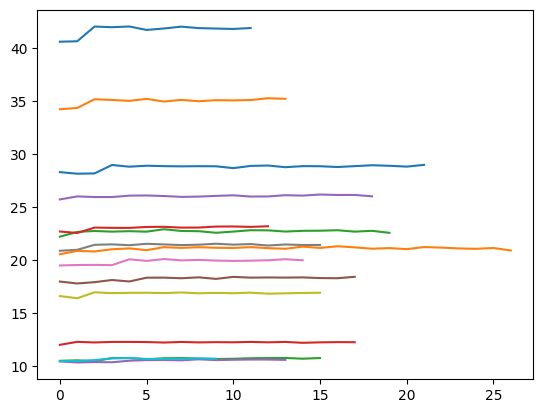

In [2]:
from matplotlib import pyplot as plt

for i in history['episodes_rewards']:
	plt.plot(history['episodes_rewards'][i])

array([29.52019944, 29.5255816 , 29.52947039, 29.53379103, 29.53377679,
       29.54556316, 29.54501081, 29.54500591, 29.54970761, 29.54977013,
       29.55151992, 29.5649452 , 29.58748711, 29.60229059, 29.60268902,
       29.60614665, 29.60638555, 29.60920663, 29.61105931, 29.61680926,
       29.61920523, 29.68040622, 29.69468671, 29.69599363, 29.69702015,
       29.69477996, 29.72220422, 29.72553601, 29.72520427, 29.72634842,
       29.72714675, 29.74011215, 29.74211764, 29.74271286, 29.74270088,
       29.7432889 , 29.74840254, 29.7483115 , 29.74703444, 29.74720209,
       29.74719452, 29.74688129, 29.7471247 , 29.75966752, 29.76253702,
       29.77403944, 29.77512952, 29.77654849, 29.78438838, 29.78678392,
       29.78607776, 29.78584485, 29.78660044, 29.78620263, 29.78588692,
       29.78566613, 29.78567236, 29.79131181, 29.79114412, 29.79103826,
       29.79649374, 29.79698559, 29.79818829, 29.79762623, 29.79849483,
       29.79848827, 29.79849002, 29.79860857, 29.79731267, 29.79

In [5]:
len(average_reward), len(deviation_reward)

(501, 501)

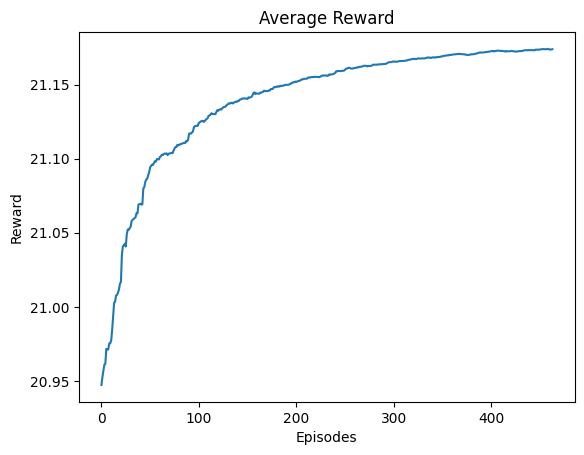

In [11]:
nice_index = [np.isnan(average_reward[i]) for i in range(len(average_reward))].index(True)
plt.title("Average Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.plot(average_reward[nice_index + 1:])

#### Optuna for settings (hyperparameters - actor critic)

In [ ]:
import random; random.seed(0)
import numpy as np; np.random.seed(0)

from utils import train_agent
# from Concept_Mining.ConceptMining import AdaptationEngine
import pickle,  pandas as pd
import seaborn as sns

from tqdm import tqdm
import optuna, os
import mlflow

def get_or_create_experiment(experiment_name):


    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)
    
def champion_callback(study, frozen_trial):
    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            print(
                f"Trial {frozen_trial.number:2d} achieved value: {frozen_trial.value:.3f}"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")
    

def run_training(settings: dict) -> tuple:

    average_reward, deviation_reward, history = train_agent(settings)
    return average_reward, deviation_reward, history

def optuna_reward( trial: optuna.Trial, settings: dict ) -> float:
    
	with mlflow.start_run(nested=True):

		hyperparameters = {
			# "interm_layer_size": trial.suggest_int('interm_layer_size', 1, 100),
			"lr_critic" : trial.suggest_float('lr_critic', 2e-5, 1e-3),
			"temperature" : trial.suggest_float('temperature', 2, 5),
		}

		hyperparameters["lr_actor"] =  trial.suggest_float('lr_actor', 2e-5, 
															hyperparameters["lr_critic"])
		hyperparameters["final_temperature"] = trial.suggest_float('final_temperature', 
																	0.3, 0.5*hyperparameters["temperature"])

		mlflow.log_params(hyperparameters)
		average_reward, _, _ = run_training(settings | hyperparameters)

	mlflow.log_metric('average_reward', study.best_value, step=trial.number)
	return max(average_reward)

BUFFER_SIZE = int(os.getenv('BUFFER_SIZE', None))


if __name__ == '__main__':

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    mlflow.set_tracking_uri(uri='http://localhost:8000')
    mlflow.set_experiment(f'Actor-Critic Buffer Size: {BUFFER_SIZE}')
    print(f'Experiment - Buffer size: {BUFFER_SIZE}')

    with mlflow.start_run(experiment_id=get_or_create_experiment(f'Actor-Critic Buffer Size: {BUFFER_SIZE}'),
                          run_name='optuna', nested=True):
        
        settings = {'episodes': 'bert-base-uncased',
            'episode_length': 1000,
            'episodes': 100,
            'gamma': 0.99,
            'decay_rate': 0.99,
            'buffer_size': BUFFER_SIZE}
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: optuna_reward(trial, settings), n_trials=10)

        mlflow.log_params(study.best_params)
        # _ = run_training( settings | st udy.best_params)

        # model = AdaptationEngine( settings | study.best_params )
        # model.Actor.load('actor.pt')
        # model.Critic.load('critic.pt')

        # # signature = mlflow.models.signature.infer_signature(df_train['text'].to_list(), 
        # #                                             model.predict(data = df_train['text'].to_list()))

        # model_info = mlflow.pytorch.log_model(model, artifact_path="ofenseval_learn", 
        #                                 signature=signature,
        #                                 registered_model_name="offenseval_learn_quickstart")
